In [0]:
#google drive connection
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
#import bibs
import os
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import cv2
import tensorflow as tf
import pydot
import gc
import keras
from tqdm import tqdm

from tensorflow.python.keras import backend as K
from tensorflow.python.keras.models import Model, load_model
from tensorflow.python.keras.layers import Input, average
from tensorflow.python.keras.layers.core import Dropout, Lambda
from tensorflow.python.keras.layers.convolutional import Conv2D, Conv2DTranspose
from tensorflow.python.keras.layers.pooling import MaxPooling2D
from tensorflow.python.keras.layers.merge import concatenate
from tensorflow.python.keras import optimizers
from tensorflow.python.keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.utils.vis_utils import plot_model

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold, train_test_split


Using TensorFlow backend.


In [0]:
#data paths from drive
data_dir = os.path.join(os.getcwd(), 'drive/My Drive/Colab Notebooks/data')

img_dir = os.path.join(data_dir, 'images_test') #hfusg images of atopic dermatitis 
mask_dir = os.path.join(data_dir, 'masks_test') #masks of SLEB layer

In [0]:
#data preparation
X, y = [], []
IMG_WIDTH, IMG_HEIGHT = 256, 256

#looping through image files
for file in tqdm(os.listdir(img_dir)):
    
    fullpath = os.path.join(img_dir, file)
    img = cv2.imread(fullpath)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    #resize images to the size of network input
    img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
    X.append(img)


#loop through mask files
for file in tqdm(os.listdir(mask_dir)):
    
    fullpath = os.path.join(mask_dir, file)
    #get into .mat file from matlab, where masks are storaged
    mat_file =  sio.loadmat(fullpath)
    mat_e= mat_file['E']
    mat_e= mat_e['e']
    mat_arrs = mat_e[0].ravel()
    arrs = mat_arrs[0]
    arr = arrs[0,0]['azs']
    #resize images to the size of network input
    arr = cv2.resize(arr, (IMG_WIDTH, IMG_HEIGHT))
    y.append(arr)

print(arr.shape)
print(img.shape)

100%|██████████| 3493/3493 [19:58<00:00,  2.91it/s]

(256, 256)
(256, 256, 3)


In [0]:
#correction of data - unifying images and masks dimensions
X, y = np.array(X), np.array(y)

print(X.shape)
print(y.shape)

(3493, 256, 256, 3)
(3493, 256, 256)


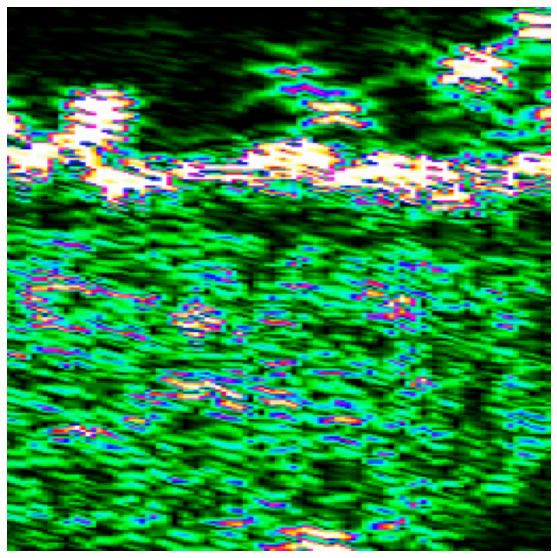

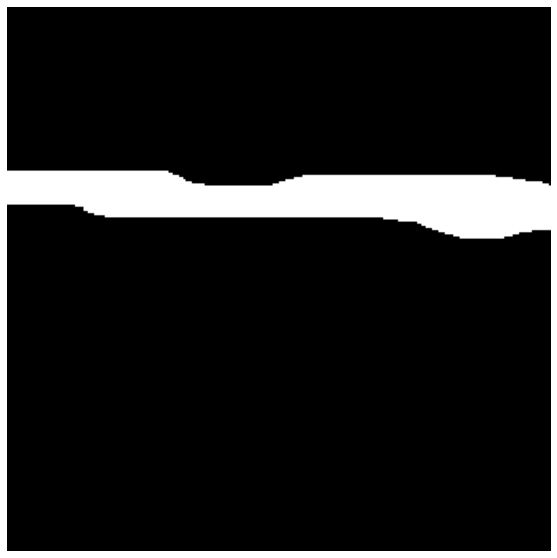

In [0]:
#sanity check - image and mask
plt.figure(figsize=(10,10))
plt.imshow(X[1], cmap='gray')
plt.axis('off')

plt.figure(figsize=(10,10))
plt.imshow(y[1], cmap='gray')
plt.axis('off')

x_length = len(X)
y = y.reshape((x_length,256,256,1))

In [0]:
#data augmentation setup
def data_aug(X_train,y_train,batch):

    data_gen_args = dict(#featurewise_center=True,
        #featurewise_std_normalization=True,
        #rotation_range=10.,
        #width_shift_range=0.1,
        #height_shift_range=0.1,
        #zoom_range=0.2,
        #rescale=1./255,
        validation_split=0.2,
        #horizontal_flip=1,
        #vertical_flip=1
        )
    image_datagen = ImageDataGenerator(**data_gen_args)
    mask_datagen = ImageDataGenerator(**data_gen_args)

    seed = 1
    image_datagen.fit(X_train, augment=True, seed=seed)
    mask_datagen.fit(y_train, augment=True, seed=seed)

    img_train_generator = image_datagen.flow(X_train, batch_size=batch, shuffle=False, subset='training', seed=seed)
    mask_train_generator = mask_datagen.flow(y_train, batch_size=batch, shuffle=False,subset='training', seed=seed)

    img_val_generator = image_datagen.flow(X_train, batch_size=batch, shuffle=False, subset='validation', seed=seed)
    mask_val_generator = mask_datagen.flow(y_train, batch_size=batch, shuffle=False, subset='validation', seed=seed)
    
    train_steps = img_train_generator.n // batch
    val_steps = img_val_generator.n // batch

    train_generator = zip(img_train_generator, mask_train_generator)
    val_generator = zip(img_val_generator, mask_val_generator)
    
    return (train_generator, val_generator, train_steps, val_steps)

In [0]:
#metric function: Intersection over Union IoU (Jaccard Index)
def mean_iou(y_true, y_pred):
    y_pred = K.cast(K.greater(y_pred, .5), dtype='float32') # .5 is the threshold
    inter = K.sum(K.sum(K.squeeze(y_true * y_pred, axis=3), axis=2), axis=1)
    union = K.sum(K.sum(K.squeeze(y_true + y_pred, axis=3), axis=2), axis=1) - inter
    return K.mean((inter + K.epsilon()) / (union + K.epsilon()))

In [0]:
#loss function: combine Dice Index loss with binary crossentropy
def dice_loss(y_true, y_pred):
    smooth = 1.
    intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
    union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
    dice = 1 - K.mean((2. * intersection + smooth) / (union + smooth), axis=0)
    return dice

def bce_dice_loss(y_true, y_pred):
    return keras.losses.binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

In [0]:
#define convolutional neural network model (u-net architecture)

def create_unet(img_height, img_width, channels): 
    inputs = Input((img_height, img_width,  channels))
    s = Lambda(lambda x: x / 255) (inputs)

    c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
    c1 = Dropout(0.1) (c1)
    c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
    p1 = MaxPooling2D((2, 2)) (c1)

    c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
    c2 = Dropout(0.1) (c2)
    c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
    p2 = MaxPooling2D((2, 2)) (c2)

    c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
    c3 = Dropout(0.2) (c3)
    c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
    p3 = MaxPooling2D((2, 2)) (c3)

    c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
    c4 = Dropout(0.2) (c4)
    c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

    c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
    c5 = Dropout(0.3) (c5)
    c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
    c6 = Dropout(0.2) (c6)
    c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
    c7 = Dropout(0.2) (c7)
    c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
    c8 = Dropout(0.1) (c8)
    c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
    c9 = Dropout(0.1) (c9)
    c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

    #output is a mask size of 256x256
    outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss=[bce_dice_loss], metrics=[mean_iou, dice_coef])
    model.summary()
    return model

In [0]:
#callbacks setting
def callbacks():
    
    callback = []
    tb = TensorBoard(log_dir='logs', histogram_freq=0,
                          write_graph=True, write_images=False)
    callback.append(tb)
    #adding different callbacks
    
    #checking learning progress
    checkpoint = ModelCheckpoint(filepath=model_name,
                             monitor = "val_loss",
                             mode = "min",
                             save_best_only = True,
                             verbose = 2)
    callback.append(checkpoint)
    #early stoppage of epoch
    earlystop = EarlyStopping(monitor="val_loss", #val_loss 
                              min_delta = 0, 
                              patience = 30,
                              mode="min",
                              verbose = 2,
                              restore_best_weights = True)
    callback.append(earlystop)

    #reducing learning rate value 
    reducelr = ReduceLROnPlateau(monitor='val_loss', 
                                  factor = 0.2,
                                  patience = 25, 
                                  mode = "min",
                                  min_lr = 0.00001, 
                                  verbose = 2)
    callback.append(reducelr)
    
    return callback

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


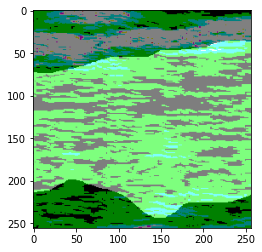

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


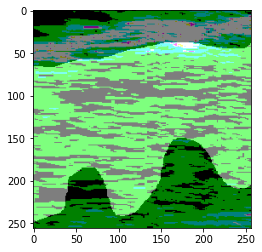

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


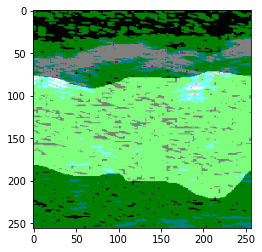

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


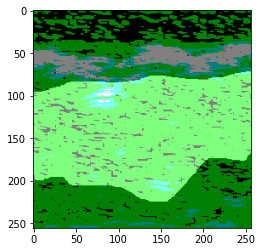

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


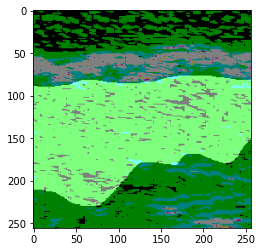

In [0]:
#sanity check on data with masks using imagedatagenerator
batch_size = 32
train_generator, val_generator, train_steps, val_steps = data_aug(X, y, batch_size)
x_batch, y_batch = next(train_generator)
for i in range (0,5):
    image = x_batch[i]
    plt.imshow(image)
    mask = y_batch[i]
    mask = mask.reshape(256,256)
    plt.imshow(mask, cmap='gray', alpha=0.5)
    plt.show()


In [0]:
#kfold cross- validation and training
kfold = KFold(n_splits=4, shuffle=True)
cvscores = []
fold_number = 1
for train, test in kfold.split(X, y):
    model_name = "/content/drive/My Drive/Colab Notebooks/" + "model_fold" + str(fold_number) + ".h5"
    weights_name = "/content/drive/My Drive/Colab Notebooks/" + "model_fold" + str(fold_number) + "_weights_only.h5"
    K.clear_session()
    callback = callbacks()

    #create unet model
    model = create_unet(IMG_HEIGHT,IMG_WIDTH,3)
    epochs = 100

    batch_size = 16 
    train_generator, val_generator, train_steps, val_steps = data_aug(X[train], y[train], batch_size)
      
    history = model.fit_generator(train_generator, validation_data=val_generator, epochs=epochs, 
                          validation_steps= val_steps, 
                          steps_per_epoch= train_steps, 
                          callbacks=callback)

    #save model from the current fold
    model.save(model_name)
    #save weights
    model.save_weights(weights_name)
    #evaluate model
    scores = model.evaluate(X[test], y[test], verbose=2)
    print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
    cvscores.append(scores[1] * 100)   
    
    fold_number = fold_number + 1

print("%s: %.2f%%" % ("Mean Accuracy: ",np.mean(cvscores)))
print("%s: %.2f%%" % ("Standard Deviation: +/-", np.std(cvscores)))

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 256, 256, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 16) 448         lambda[0][0]                     
__________________________________________________________________________________________________
dropout (Dropout)               (None, 256, 256, 16) 0           conv2d[0][0]                     
______________________________________________________________________________________________

In [0]:
#ensembling models created by cross-validation
def ensemble(models, model_input):
    
    Models_output=[model(model_input) for model in models]
    avg = average(Models_output)
    
    modelEnsemble = Model(inputs=model_input, outputs=avg, name='ensemble')
    modelEnsemble.summary()
    modelEnsemble.compile(optimizer='adam', loss=[bce_dice_loss], metrics=[mean_iou, dice_coef])
    return modelEnsemble

In [0]:
model_fold_1 = create_unet(IMG_HEIGHT,IMG_WIDTH,3)
model_fold_2 = create_unet(IMG_HEIGHT,IMG_WIDTH,3)
model_fold_3 = create_unet(IMG_HEIGHT,IMG_WIDTH,3)
model_fold_4 = create_unet(IMG_HEIGHT,IMG_WIDTH,3)

models = []

#load weights from each model
model_fold_1.load_weights('model_fold_1.h5')
models.append(model_fold_1)

model_fold_2.load_weights('model_fold_2.h5')
models.append(model_fold_2)

model_fold_3.load_weights('model_fold_3.h5')
models.append(model_fold_3)

model_fold_4.load_weights('model_fold_4.h5')
models.append(model_fold_4)

model_input = Input(shape=models[0].input_shape[1:])
ensemble_model = ensemble(models, model_input)

In [0]:
model_name = 'unet_ensembled.h5'
ensemble_model.save(model_name)

#plot network architecture
plot_model(ensemble_model, show_shapes=True, show_layer_names=False)
img = cv2.imread('model.png',1)
plt.figure(figsize=(30,15))
plt.imshow(img)


In [0]:
#network prediction of SLEB layer
x = X[1].reshape(1,256,256,3)
pred = ensemble_model.predict(x)
pred = pred.reshape(256,256)
print(np.unique(pred))

for w in range(0,256):
    for h  in range(0,256):
        
        if pred[w,h] > 0.5: #threshold of propability matrix, range [0,1].
                            #1 is 100% sureness of network pixel belongs to SLEB layer
            pred[w,h] = 1
        else:
            pred[w,h] = 0
plt.figure(figsize=(10,10))
plt.imshow(pred, cmap='gray')
plt.axis('off')